# KC Housing data

Hi Greg, this is mostly so I can play with git but once we're both comfortable I was thinking that we could use this as the final jupyter notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import itertools as itt
import statsmodels.api as sm

%matplotlib inline

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
print('View ' + str(round(df.isna().sum()['view']/len(df.view) *100, 2)) + ' % NaN')

print('Waterfront ' + str(round(df.isna().sum()['waterfront']/len(df.waterfront) *100, 2)) + ' % NaN')

print('Year Renovated ' + str(round(df.isna().sum()['yr_renovated']/len(df.yr_renovated) *100, 2)) + ' % NaN')

View 0.29 % NaN
Waterfront 11.0 % NaN
Year Renovated 17.79 % NaN


In [4]:
# Change all unclear header names to ones we like

df = df.rename(columns={'date' : 'date_sold'})
df = df.rename(columns={'price' : 'price_sold'})
df = df.rename(columns={'view' : 'view_grade'})
df = df.rename(columns={'sqft_above' : 'sqft_not_basement'})
df = df.rename(columns={'sqft_living15' : 'sqft_living_15_neighbours'})
df = df.rename(columns={'sqft_lot15' : 'sqft_lot_15_neighbours'})

In [5]:
# SAY WHY WE USE MEDIAN

df = df.fillna(value={'yr_renovated' : 0})
df = df.fillna(value={'view_grade' : df.view_grade.median()})
df = df.fillna(value={'waterfront' : df.waterfront.median()})

In [6]:
# EXPLAIN MATHS

df.sqft_basement = (df.sqft_living - df.sqft_not_basement)

In [7]:
# WHY INT64

df.date_sold = pd.to_datetime(df.date_sold)
df.yr_renovated = df.yr_renovated.astype('int64')

In [8]:
# Strange outliers
# There is a 33 bedroom house, after comparing this property with other 3 bedroom houses we decided that there had been a 
# typo in data entry and that the 33 bedrooms should become a 3 bedroom property

df.loc[df['bedrooms'] == 33]

,id,date_sold,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_grade,...,grade,sqft_not_basement,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living_15_neighbours,sqft_lot_15_neighbours
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [9]:
df.loc[df['bedrooms'] == 3].head(3)

,id,date_sold,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_grade,...,grade,sqft_not_basement,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living_15_neighbours,sqft_lot_15_neighbours
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [10]:
# This changes the 33 into a 3

df.loc[df['bedrooms'] == 33, 'bedrooms'] = 3

# Questions

## 1) How does the location affect the price?

## 2) Can categorise the houses?

We split the hosues into price quartiles.

In [11]:
df.columns

Index(['id', 'date_sold', 'price_sold', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view_grade', 'condition', 'grade',
       'sqft_not_basement', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living_15_neighbours',
       'sqft_lot_15_neighbours'],
      dtype='object')

In [12]:
# We need to remove any variables that cannot be manipulated after purchasing a property
# For example if the property was not by the waterfront and had a bad view there's not a lot we can do to change that

df_control =df.drop(['id', 'date_sold', 'waterfront', 'view_grade', 'condition', 'grade', 'yr_built',
                     'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living_15_neighbours','sqft_lot_15_neighbours'],
                    axis=1)

In [13]:
df_control_priceq1 = df_control.loc[df_control['price_sold'] < df_control.price_sold.quantile(.25)]
df_control_priceq1.head()

,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_not_basement,sqft_basement
0,221900.0,3,1.00,1180,5650,1.0,1180,0
2,180000.0,2,1.00,770,10000,1.0,770,0
6,257500.0,3,2.25,1715,6819,2.0,1715,0
7,291850.0,3,1.50,1060,9711,1.0,1060,0
8,229500.0,3,1.00,1780,7470,1.0,1050,730


In [14]:
df_control_priceq2 = df_control.loc[(df_control['price_sold'] > df_control.price_sold.quantile(.25)) 
                                    & (df_control['price_sold'] < df_control.price_sold.quantile(.50))]
df_control_priceq2.head()

,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_not_basement,sqft_basement
9,323000.0,3,2.50,1890,6560,2.0,1890,0
13,400000.0,3,1.75,1370,9680,1.0,1370,0
16,395000.0,3,2.00,1890,14040,2.0,1890,0
20,385000.0,4,1.75,1620,4980,1.0,860,760
24,329000.0,3,2.25,2450,6500,2.0,2450,0


In [15]:
df_control_priceq3 = df_control.loc[(df_control['price_sold'] > df_control.price_sold.quantile(.5)) 
                                    & (df_control['price_sold'] < df_control.price_sold.quantile(.75))]
df_control_priceq3.head()

,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_not_basement,sqft_basement
1,538000.0,3,2.25,2570,7242,2.0,2170,400
3,604000.0,4,3.00,1960,5000,1.0,1050,910
4,510000.0,3,2.00,1680,8080,1.0,1680,0
11,468000.0,2,1.00,1160,6000,1.0,860,300
14,530000.0,5,2.00,1810,4850,1.5,1810,0


In [16]:
df_control_priceq4 = df_control.loc[df_control['price_sold'] > df_control.price_sold.quantile(.75)]
df_control_priceq4.head()

,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_not_basement,sqft_basement
5,1230000.0,4,4.50,5420,101930,1.0,3890,1530
10,662500.0,3,2.50,3560,9796,1.0,1860,1700
15,650000.0,4,3.00,2950,5000,2.0,1980,970
21,2000000.0,3,2.75,3050,44867,1.0,2330,720
26,937000.0,3,1.75,2450,2691,2.0,1750,700


We decided to split the houses down further by the number of floors they have. This will allow us to talk about cheap flats/ expensive houses etc.

## 3) For each category what are the best three variables to target in order to raise the price? Are any variables globally good?

Of the seven variables (not counting price sold) that we have left we want to find a way of picking the three with the most impact on the price. We decided that this would correspond to the model with the highest R squared value. To find the best R squared value we created a function that performed linear regresion on every combination of three variables out of our list of impactful variables.

In [17]:
# A function that can take any of our dataframes and returns an R2 ranking for each group of 3 of its columns


def r2(data):
    head_list = list(data.drop('price_sold', axis=1).columns)
    combins = list(itt.combinations(head_list, 3))
    r2data = pd.DataFrame()
    for i in range(len(combins)):
        headvar1 = combins[i][0]
        headvar2 = combins[i][1]
        headvar3 = combins[i][2]
        triple = '{}, {}, and {}'.format(headvar1, headvar2, headvar3)
        minidf = pd.DataFrame({headvar1:data[headvar1], headvar2:data[headvar2],
                               headvar3:data[headvar3], 'price_sold':data['price_sold']})
        X = minidf.drop('price_sold',axis=1)
        y = minidf['price_sold']

        # Setting up the LEARNER
        X = sm.add_constant(X)
        model_sm = sm.OLS(y,X)

         # Actually LEARNING
        results = model_sm.fit()

        # Evaluating performance
        r2 = results.rsquared.round(2)
        
        # Add to the R2 dataframe
        triple_r2_df = pd.DataFrame(data = {'Triples': [triple, 'delete me'], 'R_squared': [r2,'and me']})
        triple_r2_df = triple_r2_df[:1]
        
        r2data = r2data.append(triple_r2_df, ignore_index=True)
        
    r2data = r2data.set_index('Triples')
    r2data = r2data.sort_values(by=['R_squared'])
    return r2data


In [18]:
# A sorted (ascending) dataframe of R squared values for various models

r2(df_control).head()

,R_squared
Triples,
"bedrooms, sqft_lot, and floors",0.15
"bedrooms, sqft_lot, and sqft_basement",0.16
"sqft_lot, floors, and sqft_basement",0.23
"bedrooms, floors, and sqft_basement",0.24
"bedrooms, bathrooms, and sqft_lot",0.28


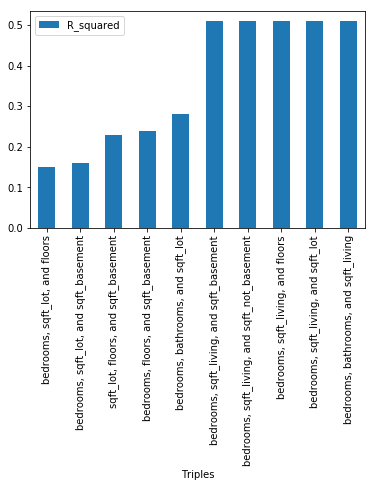

In [19]:
# Ploting the R squared values for the five worst and five best models

r2(df_control)[:5].append(r2(df_control)[-5:]).plot.bar()

In the above we see that the best global price model would be one made out of bedrooms, bathrooms, and sqft living. We now want to produce one of these graphs for each of our categories so we can match a best model to each one.